# Introduction to Ensemble Models in Python

### Why do we care?
- Ensemble models are really popular, provide good performance whilst remaining less computationally intensive and require less data than other techniques such as deep learning. 

### Goal
- Connecting the theory behind ensembles with their implementation in Python

### Agenda
- Intuition
- Weak learner: Decision Tree
- Bagging: Random Forest
- Boosting: Gradient Boosting
- Other boosting libraries

## Intuition

### Ensembles
- Combinining multiple simple models (weak learner) into a larger one (ensemble)
- Two popular techniques: bagging and boosting, usually with decision trees as weak learner

### An example

![](img/doctors.png)

You see three doctors, all of them tell you have a given disease. If we assumee all doctors take their decision independently and have a known accuracy of 75%, what's the likelihood that you really have the disease?

Let's simulate it with numpy!

In [2]:
import numpy as np

Here we'll run this experiment for 1000 patients so we can calculate probabilities on the result.

In [3]:
n_observations = 1000

In [4]:
from numpy.random import random

predictor = lambda threshold: random(n_observations) > threshold

In [5]:
np.sum(predictor(.25)) / n_observations

0.757

In [6]:
from functools import partial

predict_75 = partial(predictor, .25)

In [7]:
np.sum(predict_75()) / n_observations

0.74

Let's simulate 1000 predictions for 3 different, independent models:

In [8]:
n_models = 3
predictions = np.array([predict_75() for _ in range(n_models)]).T

In [9]:
predictions

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True, False],
       [ True,  True,  True],
       [ True,  True,  True]])

Let's create an "ensemble" that takes the majority vote from the three models for our 1000 predictions:

In [10]:
majority_vote = np.sum(predictions, axis=1) > n_models//2

In [11]:
#majority_vote

Let's check the accuracy of the new model:

In [12]:
np.sum(majority_vote) / n_observations

0.857

2 constraints:
- Models make independent predictions
- Models have an accuracy higher than 50%

With perfectly correlated models:

In [13]:
predictions = np.array([predict_75()] * n_models).T

In [14]:
predictions

array([[False, False, False],
       [ True,  True,  True],
       [False, False, False],
       ...,
       [False, False, False],
       [ True,  True,  True],
       [ True,  True,  True]])

All same predictions, so the accuracy will be same as original model

With models that have less than 50% accuracy:

In [15]:
predict_40 = partial(predictor, .60)

In [16]:
np.sum(predict_40()) / n_observations

0.399

In [17]:
predictions = np.array([predict_40() for _ in range(n_models)]).T
majority_vote = np.sum(predictions, axis=1) > n_models//2
np.sum(majority_vote) / n_observations

0.365

### Load dataset

Data from many posts on Facebook pages.

Download: https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

Features include:
- Page category
- Total number of comments on the page
- Number of comments on the page in last 24h
- etc...

The target (column 54) here is the number of comments the post will receive in the next hour. That's a regression, we will change the problem to a classification by asking:

`Will this post be commented on in the next hour?`

In [18]:
import pandas as pd

df = pd.read_csv("Dataset/Training/Features_Variant_1.csv", 
                 header=None,
                 names=["X" + str(i) for i in range(1, 55)])

df.sample(n=10)

/home/kevin/projects/cspark/talks/europython2018_walking_the_random_forest/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54
32437,274207,0,100435,18,2.0,664.0,134.565854,74.0,136.996428,0.0,...,0,0,1,0,0,0,0,0,0,1
25529,29392,0,597,91,0.0,21.0,1.830986,1.0,2.762862,0.0,...,0,0,0,1,0,0,0,0,0,0
9975,4233,0,1005,18,0.0,44.0,6.013953,4.0,7.095678,0.0,...,0,1,1,0,0,0,0,0,0,0
26033,18216,0,1264,24,4.0,42.0,18.736842,14.0,10.436989,0.0,...,0,0,0,1,0,0,0,0,0,2
4989,4290409,11,131422,9,0.0,1184.0,140.889952,65.0,203.263664,0.0,...,0,0,0,0,0,0,1,0,0,31
16152,3150,0,5,80,0.0,40.0,2.758065,0.0,6.171437,0.0,...,1,0,1,0,0,0,0,0,0,0
6456,32590,129,628,50,0.0,40.0,3.000000,1.0,5.684409,0.0,...,1,0,0,0,0,0,0,0,1,1
3230,1055660,0,120305,18,11.0,947.0,183.764706,104.0,204.633924,0.0,...,0,0,0,0,0,0,1,0,0,5
25379,367390,0,2678,100,0.0,107.0,11.753138,7.0,15.139026,0.0,...,0,0,0,0,0,0,1,0,0,0
4602,104037,0,30,14,0.0,113.0,6.748691,4.0,11.213291,0.0,...,0,0,0,0,0,1,0,0,0,0


In [19]:
df.shape

(40949, 54)

Get features and target

In [20]:
X = df.iloc[:,:53]

In [21]:
df.iloc[:,53].apply(lambda x: 1 if x > 0 else 0).value_counts()

0    22579
1    18370
Name: X54, dtype: int64

In [22]:
y = df.iloc[:,53].apply(lambda x: 1 if x == 0 else 0)

Split dataset into training & testing set

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

### Weak Learner -  Decision Trees

* Can capture complex relationship in the data [can get good enough accuracy]
* Overfits easily [good to create different models]

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=2)

In [25]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

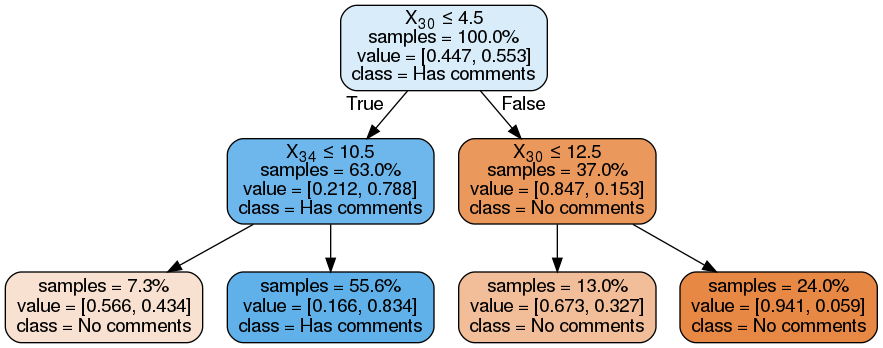

In [26]:
Image(get_tree_as_image(dt))

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(dt.predict(X_test), y_test)

0.8122100122100122

Good, but that a really simplistic model. In practice we might want to add more complexity to capture more complex relationships in the data than three binary rules. Let's increase the depth of our tree!

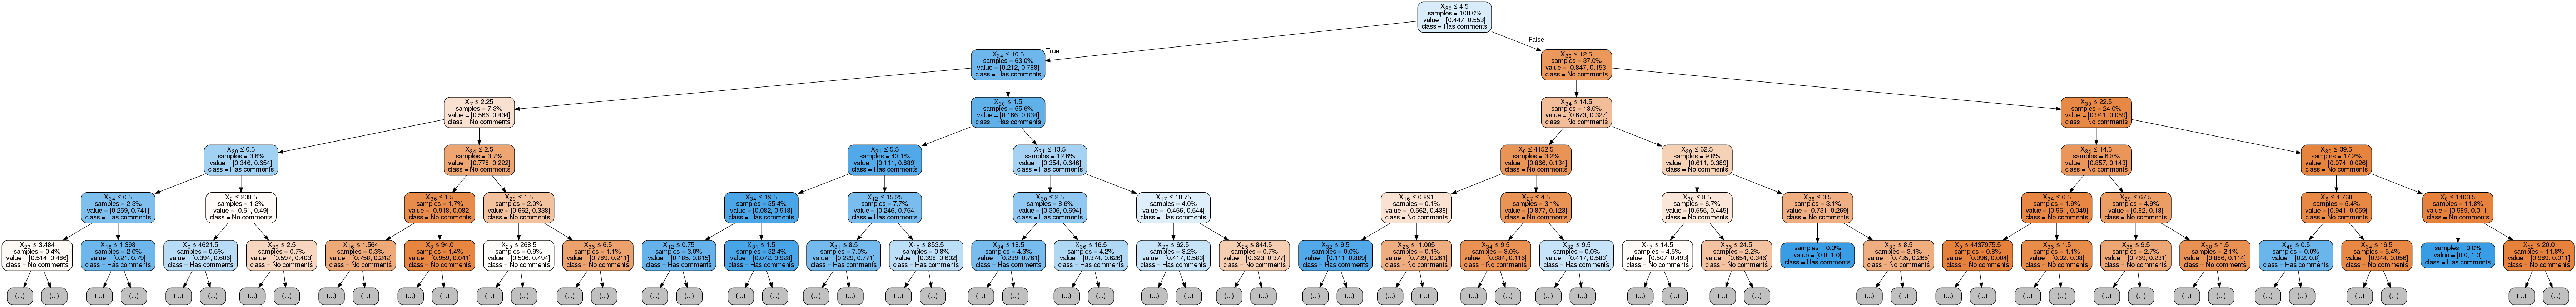

In [28]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
Image(get_tree_as_image(dt))

In [29]:
accuracy_score(dt.predict(X_test), y_test)

0.8202686202686202

Accuracy has increased a little. But if we look at the plot, we see that some nodes are created for only a few data points (.1% of the data) whilst other keep 22% of the data. 

That seems like overfitting to noise, how can we prevent that without reducing our max depth? 

Here comes `min_sample_split`, the minimum number of samples required to make a split.

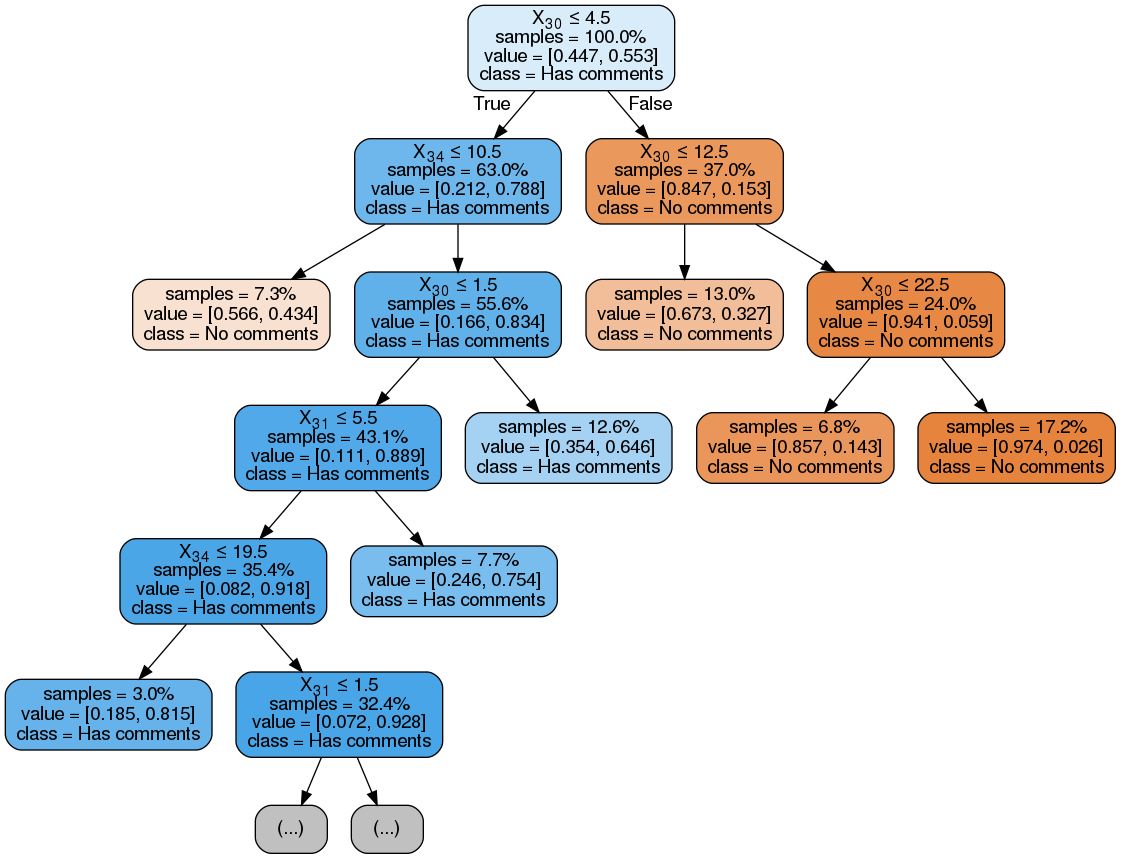

In [30]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=.2)
dt.fit(X_train, y_train)
Image(get_tree_as_image(dt))

### Bagging - Random Forest

![](img/random_forest.png)

In order to make trees not correlated we can:
- Train each on a subsample of observations (bootstrap)
- Train each on a subsample of features
- Loosely constrain trees to let them overfit (but not too much)

In [31]:
from sklearn.ensemble import RandomForestClassifier

/home/kevin/projects/cspark/talks/europython2018_walking_the_random_forest/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Let's start with 5 trees, without using the boostrap and feature sampling techniques and keeping the trees well constrained.

In [32]:
rf = RandomForestClassifier(
    # Tree parameters
    max_depth=10, min_samples_split=.2, 
    
    # Ensemble parameters
    n_estimators=5, max_features=None, bootstrap=False,

    # Misc
    random_state=42, n_jobs=-1)

In [33]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [34]:
y_pred = rf.predict(X_test)

Check accuracy

In [35]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, y_test)

0.8122100122100122

Look at estimators individually

In [36]:
rf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=0.2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=0.2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=0.2,
             min_weight_f

In [37]:
# Get the first tree
tree = rf.estimators_[0]

Check accuracy of each single tree

In [38]:
[accuracy_score(tree.predict(X_test), y_test) for tree in rf.estimators_]

[0.8122100122100122,
 0.8122100122100122,
 0.8122100122100122,
 0.8122100122100122,
 0.8122100122100122]

All trees have the exact same accuracy. Our ensemble isn't better than a single tree. Let's try again by adding both boostrap and feature sampling.

In [39]:
rf = RandomForestClassifier(
    # Tree parameters
    max_depth=10, min_samples_split=.2, 
    
    # Ensemble parameters
    n_estimators=5, max_features="auto", bootstrap=True,

    # Misc
    random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_pred, y_test)

0.821001221001221

Check accuracy of the single trees

In [40]:
[accuracy_score(tree.predict(X_test), y_test) for tree in rf.estimators_]

[0.8095238095238095,
 0.7813593813593813,
 0.7281237281237282,
 0.8087912087912088,
 0.7339031339031339]

Finally let's make our trees overfit more easily by decreasing the `min_sample_split` constraint and add more trees.

In [41]:
rf = RandomForestClassifier(
    # Tree parameters
    max_depth=10, min_samples_split=.01, 
    
    # Ensemble parameters
    n_estimators=15, max_features="auto", bootstrap=True,

    # Misc
    random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8300366300366301

Again, check accuracy on individual trees

In [42]:
[accuracy_score(tree.predict(X_test), y_test) for tree in rf.estimators_]

[0.8126984126984127,
 0.8083028083028083,
 0.8008140008140008,
 0.8219780219780219,
 0.7984533984533985,
 0.8128612128612128,
 0.7898249898249898,
 0.8043142043142043,
 0.8132682132682133,
 0.8088726088726089,
 0.8113960113960114,
 0.8012210012210013,
 0.7973951973951974,
 0.8048840048840049,
 0.8083842083842084]

### Boosting - Gradient Boosting

![](img/boosting.png)

Instead of using a set of weak learners in parallel, we build trees sequentially. Each new tree is trained to correct the errors of the previous ones. From the second tree, we use the residuals (difference between predicted value and actual one) as new training set. Trees are aggregate with decreasing weights, giving more importance to the first tree that is trained on the actual data and less on following trees that are only correcting smaller and smaller errors.

With two many stages, tt can overfit to noise
- Need to keep small, constrained trees
- Need to make sure we don't have too many stages

Can also keep the trees different to benefit from the ensemble advantage. We can use `subsample` and `max_features` for that.

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

In [44]:
gb = GradientBoostingClassifier(
    # Keep trees well constrained
    max_depth=10, min_samples_split=.2, 
    
    # Ensemble parameters
    n_estimators=5, subsample=.8, max_features="auto", learning_rate=.1,
 
    # Misc.
    random_state=42)

In [45]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=0.2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=42, subsample=0.8, verbose=0, warm_start=False)

In [46]:
y_pred = gb.predict(X_test)

Check overall accuracy

In [47]:
accuracy_score(y_pred, y_test)

0.8256410256410256

Here the accuracy of a single tree does not make sense since each new tree is correcting the error of the previous ones, not meant to predict accurately anyway. But in `sklearn` we can get the accuracy at given stage, including all trees from the previous stages.

In [48]:
[accuracy_score(y_pred, y_test) for y_pred in gb.staged_predict(X_test)]

[0.5483923483923484,
 0.7762311762311762,
 0.7826617826617827,
 0.8095238095238095,
 0.8256410256410256]

Accuracy is increasing with each new tree that we add. Maybe we're underfitting and could still get better by adding more trees? Let's try it.

We increase the number of estimators and the learning rate, so it gives more weight to each new tree correcting the error of previous ones (hence it overfits faster)

In [49]:
gb = GradientBoostingClassifier(
    # Keep trees well constrained
    max_depth=10, min_samples_split=.2, 
    
    # Ensemble parameters
    n_estimators=15, subsample=.8, max_features="auto", learning_rate=1,
 
    # Misc.
    random_state=42)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [50]:
accuracy_score(y_pred, y_test)

0.8283272283272284

Overall accuracy is a bit better, let's check the accuracy at every stage.

In [51]:
[accuracy_score(y_pred, y_test) for y_pred in gb.staged_predict(X_test)]

[0.8122100122100122,
 0.8253154253154253,
 0.8278388278388278,
 0.8288970288970289,
 0.82995522995523,
 0.8300366300366301,
 0.8301180301180301,
 0.8295482295482296,
 0.8300366300366301,
 0.8300366300366301,
 0.8311762311762312,
 0.8312576312576313,
 0.8306064306064306,
 0.8312576312576313,
 0.8283272283272284]

Accuracy went up until the 10th tree but then started decreasing as we added more. Our model started overfitting. We can decrease the number of trees, learning rate or add more constrains on our weak learners.

The sklearn implementation of gradient boosting cannot be run in parallel, hence it can be quite slow when many trees have to be trained. Several popular libraries implement optimised version of gradient boosting and can run in parallel, such as `xgboost`, `lightgbm` and `catboost`.

# Other boosting libraries - XGBoost, LightGBM, CatBoost

In [52]:
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [53]:
xgb = XGBClassifier(n_estimators=10, n_jobs=-1)
xgb.fit(X_train, y_train)
accuracy_score(xgb.predict(X_test), y_test)

/home/kevin/projects/cspark/talks/europython2018_walking_the_random_forest/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8285714285714286

In [54]:
lgb = LGBMClassifier(n_estimators=10)
lgb.fit(X_train, y_train)
accuracy_score(lgb.predict(X_test), y_test)

/home/kevin/projects/cspark/talks/europython2018_walking_the_random_forest/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.832967032967033

In [55]:
ctb = CatBoostClassifier(n_estimators=10)
ctb.fit(X_train, y_train)
accuracy_score(ctb.predict(X_test), y_test)

Learning rate set to 0.5
0:	learn: 0.4681312	total: 125ms	remaining: 1.13s
1:	learn: 0.4108439	total: 165ms	remaining: 661ms
2:	learn: 0.3888892	total: 202ms	remaining: 471ms
3:	learn: 0.3778276	total: 238ms	remaining: 358ms
4:	learn: 0.3726571	total: 276ms	remaining: 276ms
5:	learn: 0.3693396	total: 317ms	remaining: 211ms
6:	learn: 0.3672098	total: 367ms	remaining: 157ms
7:	learn: 0.3651124	total: 405ms	remaining: 101ms
8:	learn: 0.3638091	total: 453ms	remaining: 50.3ms
9:	learn: 0.3632195	total: 490ms	remaining: 0us


0.8323158323158323

### Helpers

In [1]:
# Execute this cell first to define the plot_tree function
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image  
from sklearn import tree
import pydotplus

def get_tree_as_image(dt):
    dot_data = tree.export_graphviz(dt, out_file=None, filled=True, rounded=True, special_characters=True, 
                                class_names=["No comments", "Has comments"], max_depth=5, impurity=False, 
                                    proportion=True)
    
    graph = pydotplus.graph_from_dot_data(dot_data)
    return graph.create_png()